<H1 style="text-align: center">Computer Vision</H1>
<H1 style="text-align: center"></H1>

## Imports

In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import stats
import seaborn as sns
import numpy as np
import random
import urllib
import cv2
sns.set()
plt.rcParams['figure.figsize'] = (12.0, 7.0)

print('OpenCV version: {}'.format(cv2.__version__))

OpenCV version: 4.5.1


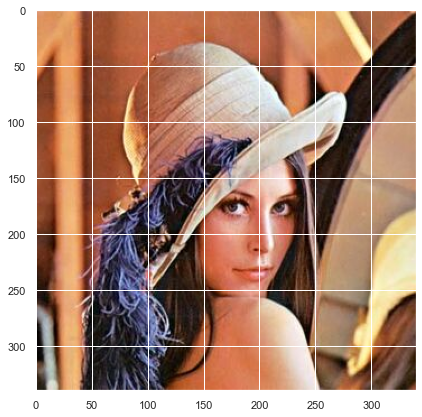

In [3]:
lena = cv2.imread('../data/Lenna.jpg')
img = cv2.cvtColor(lena, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Color Conversions
By default OpenCV loads images in BGR format.

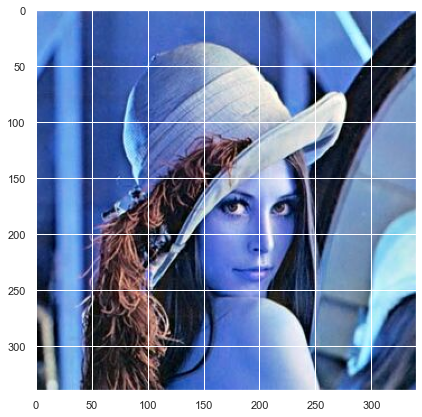

In [4]:
# convert image to RGB color space
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# show image with matplotlib
plt.imshow(img)

In [131]:
# convert image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

print('Image shape: {}'.format(gray_img.shape))
# grayscale image represented as a 2-d array
print(gray_img)

Image shape: (340, 340)
[[154 152 150 ... 160 146 108]
 [154 151 150 ... 159 150 116]
 [153 151 150 ... 173 163 128]
 ...
 [ 20  24  28 ...  71  72  69]
 [ 18  24  28 ...  81  81  78]
 [ 16  23  29 ...  82  84  82]]


Gray images have single channel

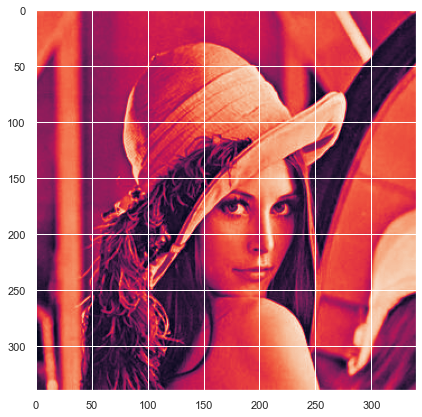

In [130]:
# plot the gray image, note the cmap parameter
plt.imshow(gray_img)

## Average color of an image

In [7]:
# find average per row
# np.average() takes in an axis argument which finds the average across that axis. 
average_color_per_row = np.average(img, axis=0)
# find average across average per row
average_color = np.average(average_color_per_row, axis=0)
# convert back to uint8
average_color = np.uint8(average_color)
print(average_color)


[ 89 111 156]


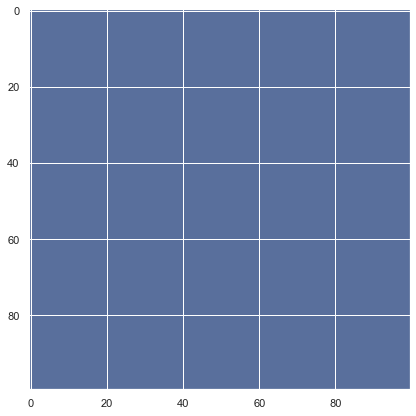

In [8]:
# create 100 x 100 pixel array with average color value
average_color_img = np.array([[average_color]*100]*100, np.uint8)

plt.imshow(average_color_img)

### Convolution from scratch using numpy

In [202]:
def convol2d(image, kernel):
    flipped_kernel = np.fliplr(np.flipud(kernel))
    padded_image = np.zeros((image.shape[0]+2, image.shape[1]+2))
    padded_image[1:-1,1:-1] = image
    result = np.zeros(image.shape)
    x = kernel.shape[0]
    y = kernel.shape[1]
    for r in range(image.shape[0]-x):
            for c in range(image.shape[1]-y):
                rc = kernel * padded_image[r:x+r, c:y+c]
                result[r, c] = rc.sum()
    return result
    

(15, 15)


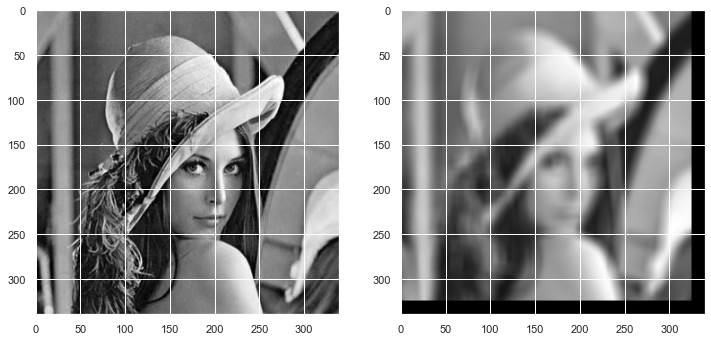

In [206]:
kernel = (1/5)*np.ones((15,15))
print(kernel.shape)
img = cv2.imread('../data/gray_img.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 2, 1); plt.imshow(gray_img, cmap='gray')
plt.subplot(1, 2, 2); plt.imshow(convol2d(img_gray, kernel), cmap='gray')
plt.savefig('../data/blurred_image')

## Box Filtering

In [ ]:
img = cv2.cvtColor(cv2.imread('images/books.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

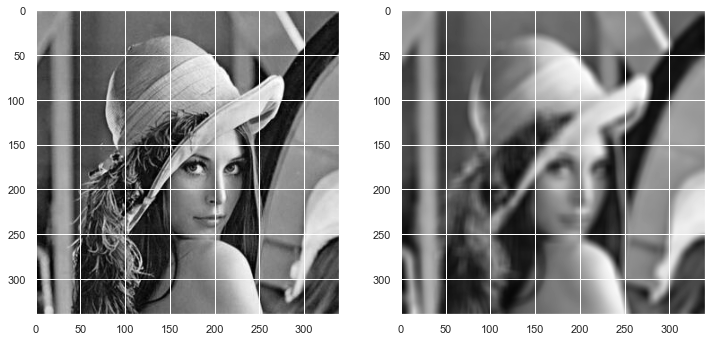

In [113]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur_img = cv2.blur(gray_img, (10, 10))
plt.subplot(1, 2, 1); plt.imshow(gray_img, cmap='gray')
plt.subplot(1, 2, 2); plt.imshow(blur_img, cmap='gray')

## Laplacian of Gaussian

In [207]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

$I (\Delta ^2 g)$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


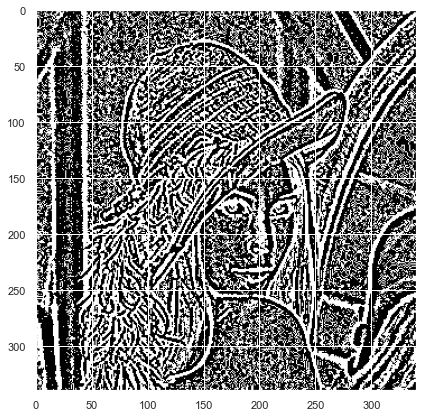

In [262]:
img = cv2.imread('../data/gray_img.png')
blur = cv2.GaussianBlur(img, (3,3), 6)
img = cv2.Laplacian(blur, cv2.CV_64F)
plt.imshow(img)

### Ringing Artifact

In [ ]:
# box filtering with 20x20 kernel
blur = cv2.blur(img, (20, 20))
plt.imshow(blur)

In [ ]:
gray_img = cv2.imread('images/grass.png')
blur_img = cv2.blur(gray_img, (25, 25))
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1); plt.imshow(gray_img, cmap='gray')
plt.subplot(1, 2, 2); plt.imshow(blur_img, cmap='gray')

## Gaussian Filtering

In [ ]:
img = cv2.cvtColor(cv2.imread('images/oy.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
# preproccess with blurring, with 5x5 kernel (note kernel size should be odd)
img_blur_small = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(img_blur_small)

In [ ]:
img_blur_small = cv2.GaussianBlur(img, (5,5), 25)
plt.imshow(img_blur_small)

In [ ]:
img_blur_large = cv2.GaussianBlur(img, (15,15), 0)
plt.imshow(img_blur_large)

## Unsharp Masking or Sharpening
\begin{align}
I_\text{sharp} &= I_\text{original} + \alpha I_\text{detail}\\
               &= I_\text{original} + \alpha I_\text{original} - \alpha I_\text{blurred}\\
               &=(1+\alpha)I_\text{original} - \alpha I_\text{blurred}
\end{align}

In [ ]:
alpha = 0.5
img = cv2.cvtColor(cv2.imread('images/oy.jpg'), cv2.COLOR_BGR2RGB)
img_sharp = cv2.addWeighted(img, 1.0 + alpha, img_blur_large, -alpha, 0)
plt.subplot(1, 3, 1); plt.imshow(img); plt.title('Original');
plt.subplot(1, 3, 2); plt.imshow(img_blur_large); plt.title('Gaussian Blurred');
plt.subplot(1, 3, 3); plt.imshow(img_sharp); plt.title('Sharp');

## Median Filtering
First create the function for creating noisy images

In [ ]:
def add_sp_noise(image, amount=0.1):
    row, col, ch = image.shape
    s_vs_p = 0.5
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    out[coords[0], coords[1], coords[2]] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    out[coords[0], coords[1], coords[2]] = 0
    return out

Load an image and apply salt and pepper noise and then try to smooth it with Gaussian and Median filter

In [ ]:
img = cv2.cvtColor(cv2.imread('images/coins.jpg'), cv2.COLOR_BGR2RGB)
noisy_img = add_sp_noise(img, amount=0.1)
img_gaus = cv2.GaussianBlur(noisy_img, (5, 5), 3)
img_med = cv2.medianBlur(noisy_img, 5)
plt.subplot(1, 4, 1); plt.imshow(img); plt.title('Original');
plt.subplot(1, 4, 2); plt.imshow(noisy_img); plt.title('Salt & Pepper Noise');
plt.subplot(1, 4, 3); plt.imshow(img_gaus); plt.title('Gaussian Filtered');
plt.subplot(1, 4, 4); plt.imshow(img_med); plt.title('Median Filtered');

## Image Gradient
Experiment with negative values. Note `cv2.CV_8U` cannot contain negative values.

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/books.jpg', 0)

laplacian = cv2.Laplacian(img, cv2.CV_8U)
sobelx = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_8U, 0, 1, ksize=5)

plt.subplot(2,2,1),plt.imshow(img, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian, cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx, cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely, cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

Note `cv2.CV_64F` can contain negative values.

In [ ]:
laplacian = cv2.Laplacian(img, cv2.CV_64F)
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

plt.subplot(2,2,1),plt.imshow(img, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian, cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx, cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely, cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

## Edge Detection
Canny edge detector on OpenCV. Usage of edge detection versus thresholding to obtain binary image.

In [ ]:
cups = cv2.cvtColor(cv2.imread('images/cups.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(cups)

In [ ]:
# preprocess by blurring and grayscale
cups_preprocessed  = cv2.cvtColor(cv2.GaussianBlur(cups, (7,7), 0), cv2.COLOR_RGB2GRAY)

In [ ]:
# find binary image with thresholding
low_thresh = 120
high_thresh = 200
_, cups_thresh = cv2.threshold(cups_preprocessed, low_thresh, 255, cv2.THRESH_BINARY)
plt.imshow(cv2.cvtColor(cups_thresh, cv2.COLOR_GRAY2RGB))

_, cups_thresh_hi = cv2.threshold(cups_preprocessed, high_thresh, 255, cv2.THRESH_BINARY)

In [ ]:
# find binary image with edges
cups_edges = cv2.Canny(cups_preprocessed, threshold1=90, threshold2=110)
plt.imshow(cv2.cvtColor(cups_edges, cv2.COLOR_GRAY2RGB))

## Binary Thresholding

Binarization converts an image to a two tone (0,255 or 0,1) image. Examples using thresholding on brightness/darkness of grayscale image and on color ranges


### On Grayscale Image

### Global Thresholding

In [ ]:
# threshold for grayscale image
img = cv2.imread('images/oy.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1); plt.imshow(gray_img, cmap='gray')
plt.subplot(1, 2, 2); plt.imshow(threshold_img, cmap='gray')

In [ ]:
#threshold on blurred image
gray_blur_img = cv2.cvtColor(img_blur_small, cv2.COLOR_BGR2GRAY)
_, threshold_img_blur = cv2.threshold(gray_blur_img, 100, 255, cv2.THRESH_BINARY)
plt.imshow(cv2.cvtColor(threshold_img_blur, cv2.COLOR_GRAY2RGB))

### Adaptive Thresholding
It is local thresholding where threshold is decided in local windows.

In [ ]:
# using adaptive threshold instead of global
adaptive_thresh = cv2.adaptiveThreshold(gray_img,255,\
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                         cv2.THRESH_BINARY,11,2)
plt.imshow(adaptive_thresh, cmap='gray')

### On Color Image

In [ ]:
# open new Mondrian Piet painting photo
piet = cv2.cvtColor(cv2.imread('images/piet.png'), cv2.COLOR_BGR2RGB)
piet_hsv = cv2.cvtColor(piet, cv2.COLOR_RGB2HSV)
plt.imshow(piet)

### Range thresholding
The HSV color space is quite similar to the way in which humans perceive color. Most of the other models define color in relation to the primary colors. The colors used in HSV can be clearly defined by human perception.

In [ ]:
# threshold for hue channel in blue range
blue_min = np.array([85, 60, 60], np.uint8)
blue_max = np.array([150, 255, 255], np.uint8)
threshold_blue_img = cv2.inRange(piet_hsv, blue_min, blue_max)

# show threshold bits
plt.imshow(threshold_blue_img, cmap='gray')

### Binary Thesholding and Image Masking

In [ ]:
upstate = cv2.cvtColor(cv2.imread('images/upstate-ny.jpg'), cv2.COLOR_BGR2RGB)
upstate_hsv = cv2.cvtColor(upstate, cv2.COLOR_RGB2HSV)
plt.imshow(upstate)

Note `bitwise_not` to filter out the blue sky

In [ ]:
mask_inverse = cv2.inRange(upstate_hsv, blue_min, blue_max)
mask = cv2.bitwise_not(mask_inverse)
plt.imshow(mask, cmap='gray')

Use the above mask to select the non sky part

In [ ]:
# convert single channel mask back into 3 channels
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# perform bitwise and on mask to obtain cut-out image that is not blue
masked_upstate = cv2.bitwise_and(upstate, mask_rgb)

# replace the cut-out parts with white
masked_replace_white = cv2.addWeighted(masked_upstate, 1, \
                                       cv2.cvtColor(mask_inverse, cv2.COLOR_GRAY2RGB), 1, 0)

plt.imshow(masked_replace_white)